CopulaGAN Model
===============

In this guide we will go through a series of steps that will let you
discover functionalities of the `CopulaGAN` model, including how to:

-   Create an instance of `CopulaGAN`.
-   Fit the instance to your data.
-   Generate synthetic versions of your data.
-   Use `CopulaGAN` to anonymize PII information.
-   Customize the data transformations to improve the learning process.
-   Specify the column distributions to improve the output quality.
-   Specify hyperparameters to improve the output quality.

What is CopulaGAN?
------------------

The `sdv.tabular.CopulaGAN` model is a variation of the
[ctgan](ctgan.ipynb) which takes advantage of the CDF
based transformation that the GaussianCopulas apply to make the
underlying CTGAN model task of learning the data easier.

Let\'s now discover how to learn a dataset and later on generate
synthetic data with the same format and statistical properties by using
the `CopulaGAN` class from SDV.

Quick Usage
-----------

We will start by loading one of our demo datasets, the
`student_placements`, which contains information about MBA students that
applied for placements during the year 2020.

<div class="alert alert-warning">

**Warning**

In order to follow this guide you need to have `ctgan` installed on your
system. If you have not done it yet, please install `ctgan` now by
executing the command `pip install sdv` in a terminal.

</div>

In [1]:
from sdv.demo import load_tabular_demo

data = load_tabular_demo('student_placements')
data.head()

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17264,M,67.00,91.00,Commerce,58.00,Sci&Tech,False,0,55.0,Mkt&HR,58.80,27000.0,True,2020-07-23,2020-10-12,3.0
1,17265,M,79.33,78.33,Science,77.48,Sci&Tech,True,1,86.5,Mkt&Fin,66.28,20000.0,True,2020-01-11,2020-04-09,3.0
2,17266,M,65.00,68.00,Arts,64.00,Comm&Mgmt,False,0,75.0,Mkt&Fin,57.80,25000.0,True,2020-01-26,2020-07-13,6.0
3,17267,M,56.00,52.00,Science,52.00,Sci&Tech,False,0,66.0,Mkt&HR,59.43,NaN,False,NaT,NaT,NaN
4,17268,M,85.80,73.60,Commerce,73.30,Comm&Mgmt,False,0,96.8,Mkt&Fin,55.50,42500.0,True,2020-07-04,2020-09-27,3.0


In [2]:
from sdv.tabular import CopulaGAN

model = CopulaGAN()
model.fit(data)

<div class="alert alert-info">

**Note**

Notice that the model `fitting` process took care of transforming the
different fields using the appropriate [Reversible Data
Transforms](http://github.com/sdv-dev/RDT) to ensure that the data has a
format that the underlying CTGANSynthesizer class can handle.

</div>

### Generate synthetic data from the model

Once the modeling has finished you are ready to generate new synthetic
data by calling the `sample` method from your model passing the number
of rows that we want to generate.

In [3]:
new_data = model.sample(200)

This will return a table identical to the one which the model was fitted
on, but filled with new data which resembles the original one.

In [4]:
new_data.head()

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17469,M,70.229411,64.625499,Commerce,83.473727,Comm&Mgmt,False,0,53.018152,Mkt&Fin,71.412744,23645.947747,True,2020-01-04,2020-07-22,6.0
1,17288,F,89.097799,54.115001,Commerce,72.322694,Comm&Mgmt,True,1,56.057410,Mkt&HR,77.515289,NaN,True,NaT,2020-04-28,3.0
2,17477,F,51.231255,53.752005,Commerce,65.193222,Sci&Tech,True,0,50.494756,Mkt&Fin,60.331734,28490.784003,True,2020-01-08,NaT,3.0
3,17468,M,67.335891,74.093303,Commerce,74.417928,Comm&Mgmt,False,0,53.010724,Mkt&Fin,68.061821,22762.301432,True,2020-01-13,2020-11-11,6.0
4,17441,F,86.307998,61.755421,Arts,74.436190,Comm&Mgmt,False,1,50.718030,Mkt&Fin,59.679836,23923.151295,True,2020-01-07,2020-08-04,3.0


<div class="alert alert-info">

**Note**

You can control the number of rows by specifying the number of `samples`
in the `model.sample(<num_rows>)`. To test, try `model.sample(10000)`.
Note that the original table only had \~200 rows.

</div>

### Save and Load the model

In many scenarios it will be convenient to generate synthetic versions
of your data directly in systems that do not have access to the original
data source. For example, if you may want to generate testing data on
the fly inside a testing environment that does not have access to your
production database. In these scenarios, fitting the model with real
data every time that you need to generate new data is feasible, so you
will need to fit a model in your production environment, save the fitted
model into a file, send this file to the testing environment and then
load it there to be able to `sample` from it.

Let\'s see how this process works.

#### Save and share the model

Once you have fitted the model, all you need to do is call its `save`
method passing the name of the file in which you want to save the model.
Note that the extension of the filename is not relevant, but we will be
using the `.pkl` extension to highlight that the serialization protocol
used is [pickle](https://docs.python.org/3/library/pickle.html).

In [5]:
model.save('my_model.pkl')

This will have created a file called `my_model.pkl` in the same
directory in which you are running SDV.

<div class="alert alert-info">

**Important**

If you inspect the generated file you will notice that its size is much
smaller than the size of the data that you used to generate it. This is
because the serialized model contains **no information about the
original data**, other than the parameters it needs to generate
synthetic versions of it. This means that you can safely share this
`my_model.pkl` file without the risc of disclosing any of your real
data!

</div>

#### Load the model and generate new data

The file you just generated can be sent over to the system where the
synthetic data will be generated. Once it is there, you can load it
using the `CopulaGAN.load` method, and then you are ready to sample new
data from the loaded instance:

In [6]:
loaded = CopulaGAN.load('my_model.pkl')
new_data = loaded.sample(200)

<div class="alert alert-warning">

**Warning**

Notice that the system where the model is loaded needs to also have
`sdv` and `ctgan` installed, otherwise it will not be able to load the
model and use it.

</div>

### Specifying the Primary Key of the table

One of the first things that you may have noticed when looking at the demo
data is that there is a `student_id` column which acts as the primary
key of the table, and which is supposed to have unique values. Indeed,
if we look at the number of times that each value appears, we see that
all of them appear at most once:

In [7]:
data.student_id.value_counts().max()

1

However, if we look at the synthetic data that we generated, we observe
that there are some values that appear more than once:

In [8]:
new_data[new_data.student_id == new_data.student_id.value_counts().index[0]]

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17478,M,49.214551,59.450584,Commerce,64.378352,Comm&Mgmt,True,0,56.628295,Mkt&HR,53.923599,19908.790796,True,2020-01-05,2020-08-14,3.0
4,17478,M,57.167930,68.315577,Commerce,65.822147,Comm&Mgmt,False,0,53.382850,Mkt&HR,57.956012,23944.901931,True,2020-04-19,NaT,3.0
5,17478,M,44.985779,40.956009,Commerce,56.800119,Comm&Mgmt,True,0,53.514374,Mkt&Fin,55.903447,19946.578486,True,2020-01-09,NaT,3.0
38,17478,M,84.031233,57.529944,Science,71.726136,Sci&Tech,False,0,59.763579,Mkt&HR,56.221129,28150.091251,True,2020-01-11,NaT,3.0
42,17478,M,58.926480,72.428575,Science,49.573910,Comm&Mgmt,False,1,76.368253,Mkt&HR,65.438787,27320.627843,True,2020-05-19,2020-07-27,NaN
46,17478,M,51.074730,64.221035,Science,80.917654,Comm&Mgmt,False,1,54.663072,Mkt&Fin,62.340741,28257.656652,True,2020-01-09,NaT,3.0
51,17478,M,89.316723,64.298559,Commerce,62.111798,Sci&Tech,False,1,52.089567,Mkt&Fin,63.769694,29446.107673,False,2020-01-07,2020-04-27,NaN
73,17478,M,79.374821,80.213679,Commerce,65.449498,Comm&Mgmt,True,0,71.690192,Mkt&HR,53.156613,23874.108051,True,NaT,2020-07-09,12.0
77,17478,M,54.072869,60.461062,Science,52.422943,Comm&Mgmt,True,0,53.326356,Mkt&HR,66.860840,NaN,True,2020-01-13,2020-07-30,NaN
91,17478,F,69.504924,61.854025,Commerce,52.446675,Others,False,0,53.647310,Mkt&Fin,63.474546,21456.548956,True,2020-05-01,2021-02-23,3.0


This happens because the model was not notified at any point about the
fact that the `student_id` had to be unique, so when it generates new
data it will provoke collisions sooner or later. In order to solve this,
we can pass the argument `primary_key` to our model when we create it,
indicating the name of the column that is the index of the table.

In [9]:
model = CopulaGAN(
    primary_key='student_id'
)
model.fit(data)
new_data = model.sample(200)
new_data.head()

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,M,79.791304,79.322160,Arts,75.413114,Sci&Tech,False,1,96.492602,Mkt&HR,62.362273,NaN,True,NaT,2020-07-10,3.0
1,1,M,89.059898,52.678735,Commerce,56.149202,Comm&Mgmt,False,0,51.105627,Mkt&Fin,72.470161,71398.175787,False,2020-01-17,2020-09-05,3.0
2,2,M,46.386179,62.958969,Commerce,57.825035,Sci&Tech,False,0,83.184077,Mkt&Fin,60.067241,29409.968985,True,NaT,2020-12-06,12.0
3,3,F,56.968205,60.760316,Science,71.457285,Comm&Mgmt,False,0,63.958794,Mkt&HR,61.292363,27860.329298,True,2020-06-17,NaT,3.0
4,4,F,82.362811,41.366776,Commerce,75.373526,Comm&Mgmt,False,1,63.936090,Mkt&Fin,51.594417,28729.154793,True,NaT,NaT,12.0


As a result, the model will learn that this column must be unique and
generate a unique sequence of values for the column:

In [10]:
new_data.student_id.value_counts().max()

1

### Anonymizing Personally Identifiable Information (PII)

There will be many cases where the data will contain Personally
Identifiable Information which we cannot disclose. In these cases, we
will want our Tabular Models to replace the information within these
fields with fake, simulated data that looks similar to the real one but
does not contain any of the original values.

Let\'s load a new dataset that contains a PII field, the
`student_placements_pii` demo, and try to generate synthetic versions of
it that do not contain any of the PII fields.

<div class="alert alert-info">

**Note**

The `student_placements_pii` dataset is a modified version of the
`student_placements` dataset with one new field, `address`, which
contains PII information about the students. Notice that this additional
`address` field has been simulated and does not correspond to data from
the real users.

</div>

In [11]:
data_pii = load_tabular_demo('student_placements_pii')
data_pii.head()

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17264,"70304 Baker Turnpike\nEricborough, MS 15086",M,67.00,91.00,Commerce,58.00,Sci&Tech,False,0,55.0,Mkt&HR,58.80,27000.0,True,2020-07-23,2020-10-12,3.0
1,17265,"805 Herrera Avenue Apt. 134\nMaryview, NJ 36510",M,79.33,78.33,Science,77.48,Sci&Tech,True,1,86.5,Mkt&Fin,66.28,20000.0,True,2020-01-11,2020-04-09,3.0
2,17266,"3702 Bradley Island\nNorth Victor, FL 12268",M,65.00,68.00,Arts,64.00,Comm&Mgmt,False,0,75.0,Mkt&Fin,57.80,25000.0,True,2020-01-26,2020-07-13,6.0
3,17267,Unit 0879 Box 3878\nDPO AP 42663,M,56.00,52.00,Science,52.00,Sci&Tech,False,0,66.0,Mkt&HR,59.43,NaN,False,NaT,NaT,NaN
4,17268,"96493 Kelly Canyon Apt. 145\nEast Steven, NC 3...",M,85.80,73.60,Commerce,73.30,Comm&Mgmt,False,0,96.8,Mkt&Fin,55.50,42500.0,True,2020-07-04,2020-09-27,3.0


If we use our tabular model on this new data we will see how the
synthetic data that it generates discloses the addresses from the real
students:

In [12]:
model = CopulaGAN(
    primary_key='student_id',
)
model.fit(data_pii)
new_data_pii = model.sample(200)
new_data_pii.head()

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,"29166 Tammy Crest Apt. 839\nSouth Lindaside, F...",M,81.950041,67.698728,Science,53.997805,Comm&Mgmt,True,0,62.879450,Mkt&HR,57.723390,26270.315166,True,2020-01-07,2020-07-09,3.0
1,1,"43733 Sara Forges Suite 447\nWest Sarahmouth, ...",F,84.901828,79.467257,Arts,76.618033,Comm&Mgmt,False,0,72.213982,Mkt&Fin,83.596046,28576.242579,False,2020-01-23,2020-09-01,NaN
2,2,"365 Rocha Center\nNew Marilyn, KS 06019",M,60.071858,50.798165,Commerce,67.633694,Comm&Mgmt,True,0,91.125479,Mkt&HR,67.616497,27851.824529,True,NaT,2020-06-18,6.0
3,3,"336 Davis Drives Apt. 411\nNew Reginashire, CT...",M,69.983469,31.550142,Commerce,67.723821,Comm&Mgmt,False,2,55.138698,Mkt&Fin,64.403275,22723.227774,True,NaT,2020-09-19,NaN
4,4,"1089 Dean Vista\nScottberg, NY 24747",M,61.922264,90.976170,Science,62.719434,Sci&Tech,False,0,52.278306,Mkt&Fin,66.755186,NaN,True,2020-06-10,2020-12-25,NaN


More specifically, we can see how all the addresses that have been
generated actually come from the original dataset:

In [13]:
new_data_pii.address.isin(data_pii.address).sum()

200

In order to solve this, we can pass an additional argument
`anonymize_fields` to our model when we create the instance. This
`anonymize_fields` argument will need to be a dictionary that contains:

-   The name of the field that we want to anonymize.
-   The category of the field that we want to use when we generate fake
    values for it.

The list complete list of possible categories can be seen in the [Faker
Providers](https://faker.readthedocs.io/en/master/providers.html) page,
and it contains a huge list of concepts such as:

-   name
-   address
-   country
-   city
-   ssn
-   credit_card_number
-   credit_card_expire
-   credit_card_security_code
-   email
-   telephone
-   \...

In this case, since the field is an e-mail address, we will pass a
dictionary indicating the category `address`

In [14]:
model = CopulaGAN(
    primary_key='student_id',
    anonymize_fields={
        'address': 'address'
    }
)
model.fit(data_pii)

As a result, we can see how the real `address` values have been replaced
by other fake addresses that were not taken from the real data that we
learned.

In [15]:
new_data_pii = model.sample(200)
new_data_pii.head()

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,35565 Eugene Prairie Suite 716\nLake Jenniferm...,M,87.634642,60.161269,Science,78.636029,Comm&Mgmt,False,0,55.228024,Mkt&Fin,69.357791,29511.500600,True,2020-02-08,NaT,NaN
1,1,USNS Reeves\nFPO AE 88232,M,42.084393,73.381165,Science,74.802564,Sci&Tech,False,0,50.510180,Mkt&Fin,50.807796,NaN,True,2020-01-12,2020-08-05,6.0
2,2,"209 Sexton View Suite 033\nEast Douglashaven, ...",F,85.783432,80.371191,Science,81.206412,Comm&Mgmt,False,0,59.269758,Mkt&HR,52.775678,32406.254014,True,2020-01-21,NaT,3.0
3,3,"898 Melinda Drive Suite 805\nWest Annshire, CA...",F,74.664718,90.550053,Science,88.476493,Sci&Tech,False,0,63.342493,Mkt&Fin,51.489479,31043.821315,False,NaT,2020-10-01,12.0
4,4,"5941 Christina Unions Apt. 542\nNew Darryl, DE...",M,73.548583,83.371315,Science,70.160225,Comm&Mgmt,False,0,51.595967,Mkt&HR,66.524814,32588.747462,True,2020-01-24,NaT,NaN


Which means that none of the original addresses can be found in the
sampled data:

In [16]:
data_pii.address.isin(new_data_pii.address).sum()

0

Advanced Usage
--------------

Now that we have discovered the basics, let\'s go over a few more
advanced usage examples and see the different arguments that we can pass
to our `CopulaGAN` Model in order to customize it to our needs.

### Exploring the Probability Distributions

During the previous steps, every time we fitted the `CopulaGAN` it
performed the following operations:

1.  Learn the format and data types of the passed data
2.  Transform the non-numerical and null data using [Reversible Data
    Transforms](https://github.com/sdv-dev/RDT) to obtain a fully
    numerical representation of the data from which we can learn the
    probability distributions.
3.  Learn the probability distribution of each column from the table
4.  Transform the values of each numerical column by converting them to
    their marginal distribution CDF values and then applying an inverse
    CDF transformation of a standard normal on them.
5.  Fit a CTGAN model on the transformed data, which learns how each
    column is correlated to the others.

After this, when we used the model to generate new data for our table
using the `sample` method, it did:

5.  Sample rows from the CTGAN model.
6.  Revert the sampled values by computing their standard normal CDF and
    then applying the inverse CDF of their marginal distributions.
7.  Revert the RDT transformations to go back to the original data
    format.

As you can see, during these steps the *Marginal Probability
Distributions* have a very important role, since the `CopulaGAN` had to
learn and reproduce the individual distributions of each column in our
table. We can explore the distributions which the `CopulaGAN` used to
model each column using its `get_distributions` method:

In [17]:
model = CopulaGAN(
    primary_key='student_id'
)
model.fit(data)
distributions = model.get_distributions()

This will return us a `dict` which contains the name of the distribution
class used for each column:

In [18]:
distributions

{'second_perc': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'high_perc': 'copulas.univariate.log_laplace.LogLaplace',
 'degree_perc': 'copulas.univariate.student_t.StudentTUnivariate',
 'work_experience': 'copulas.univariate.student_t.StudentTUnivariate',
 'experience_years': 'copulas.univariate.gaussian.GaussianUnivariate',
 'employability_perc': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'mba_perc': 'copulas.univariate.gamma.GammaUnivariate',
 'salary#0': 'copulas.univariate.gamma.GammaUnivariate',
 'salary#1': 'copulas.univariate.gaussian.GaussianUnivariate',
 'placed': 'copulas.univariate.gamma.GammaUnivariate',
 'start_date#0': 'copulas.univariate.gamma.GammaUnivariate',
 'start_date#1': 'copulas.univariate.gaussian.GaussianUnivariate',
 'end_date#0': 'copulas.univariate.gamma.GammaUnivariate',
 'end_date#1': 'copulas.univariate.gaussian.GaussianUnivariate'}

<div class="alert alert-info">

**Note**

In this list we will see multiple distributions for each one of the
columns that we have in our data. This is because the RDT
transformations used to encode the data numerically often use more than
one column to represent each one of the input variables.

</div>

Let\'s explore the individual distribution of one of the columns in our
data to better understand how the `CopulaGAN` processed them and see if
we can improve the results by manually specifying a different
distribution. For example, let\'s explore the `experience_years` column
by looking at the frequency of its values within the original data:

In [19]:
data.experience_years.value_counts()

0    141
1     65
2      8
3      1
Name: experience_years, dtype: int64

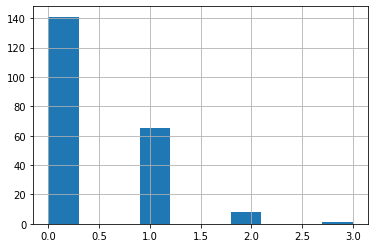

In [20]:
data.experience_years.hist();

By observing the data we can see that the behavior of the values in this
column is very similar to a Gamma or even some types of Beta
distribution, where the majority of the values are 0 and the frequency
decreases as the values increase.

Was the `CopulaGAN` able to capture this distribution on its own?

In [21]:
distributions['experience_years']

'copulas.univariate.gaussian.GaussianUnivariate'

It seems that the it was not, as it rather thought that the behavior was
closer to a Gaussian distribution. And, as a result, we can see how the
generated values now contain negative values which are invalid for this
column:

In [22]:
new_data.experience_years.value_counts()

0    169
1     30
2      1
Name: experience_years, dtype: int64

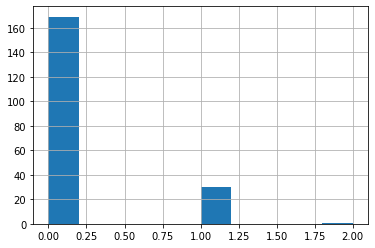

In [23]:
new_data.experience_years.hist();

Let\'s see how we can improve this situation by passing the `CopulaGAN`
the exact distribution that we want it to use for this column.

### Setting distributions for indvidual variables

The `CopulaGAN` class offers the possibility to indicate which
distribution to use for each one of the columns in the table, in order
to solve situations like the one that we just described. In order to do
this, we need to pass a `field_distributions` argument with `dict` that
indicates, the distribution that we want to use for each column.

Possible values for the distribution argument are:

-   `univariate`: Let `copulas` select the optimal univariate
    distribution. This may result in non-parametric models being used.
-   `parametric`: Let `copulas` select the optimal univariate
    distribution, but restrict the selection to parametric distributions
    only.
-   `bounded`: Let `copulas` select the optimal univariate distribution,
    but restrict the selection to bounded distributions only. This may
    result in non-parametric models being used.
-   `semi_bounded`: Let `copulas` select the optimal univariate
    distribution, but restrict the selection to semi-bounded
    distributions only. This may result in non-parametric models being
    used.
-   `parametric_bounded`: Let `copulas` select the optimal univariate
    distribution, but restrict the selection to parametric and bounded
    distributions only.
-   `parametric_semi_bounded`: Let `copulas` select the optimal
    univariate distribution, but restrict the selection to parametric
    and semi-bounded distributions only.
-   `gaussian`: Use a Gaussian distribution.
-   `gamma`: Use a Gamma distribution.
-   `beta`: Use a Beta distribution.
-   `student_t`: Use a Student T distribution.
-   `gaussian_kde`: Use a GaussianKDE distribution. This model is
    non-parametric, so using this will make `get_parameters` unusable.
-   `truncated_gaussian`: Use a Truncated Gaussian distribution.

Let\'s see what happens if we make the `CopulaGAN` use the `gamma`
distribution for our column.

In [24]:
model = CopulaGAN(
    primary_key='student_id',
    field_distributions={
        'experience_years': 'gamma'
    }
)
model.fit(data)

After this, we can see how the `CopulaGAN` used the indicated
distribution for the `experience_years` column

In [25]:
model.get_distributions()['experience_years']

'copulas.univariate.gamma.GammaUnivariate'

And, as a result, now we can see how the generated data now have a
behavior which is closer to the original data and always stays within
the valid values range.

In [26]:
new_data = model.sample(len(data))
new_data.experience_years.value_counts()

0    200
1     10
2      3
3      2
Name: experience_years, dtype: int64

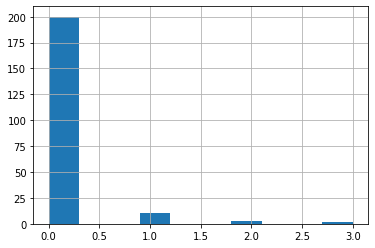

In [27]:
new_data.experience_years.hist();

<div class="alert alert-info">

**Note**

Even though there are situations like the one show above where manually
choosing a distribution seems to give better results, in most cases the
`CopulaGAN` will be able to find the optimal distribution on its own,
making this manual search of the marginal distributions necessary on
very little occasions.

</div>

### How to modify the CopulaGAN Hyperparameters?

A part from the arguments explained above, `CopulaGAN` has a number of
additional hyperparameters that control its learning behavior and can
impact on the performance of the model, both in terms of quality of the
generated data and computational time:

-   `epochs` and `batch_size`: these arguments control the number of
    iterations that the model will perform to optimize its parameters,
    as well as the number of samples used in each step. Its default
    values are `300` and `500` respectively, and `batch_size` needs to
    always be a value which is multiple of `10`. These hyperparameters
    have a very direct effect in time the training process lasts but
    also on the performance of the data, so for new datasets, you might
    want to start by setting a low value on both of them to see how long
    the training process takes on your data and later on increase the
    number to acceptable values in order to improve the performance.
-   `log_frequency`: Whether to use log frequency of categorical levels
    in conditional sampling. It defaults to `True`. This argument affects
    how the model processes the frequencies of the categorical values that
    are used to condition the rest of the values. In some cases, changing
    it to `False` could lead to better performance.
-   `embedding_dim` (int): Size of the random sample passed to the
    Generator. Defaults to 128.
-   `generator_dim` (tuple or list of ints): Size of the output samples for
    each one of the Residuals. A Resiudal Layer will be created for each
    one of the values provided. Defaults to (256, 256).
-   `discriminator_dim` (tuple or list of ints): Size of the output samples for
    each one of the Discriminator Layers. A Linear Layer will be created
    for each one of the values provided. Defaults to (256, 256).
-   `generator_lr` (float): Learning rate for the generator. Defaults to 2e-4.
-   `generator_decay` (float): Generator weight decay for the Adam Optimizer.
    Defaults to 1e-6.
-   `discriminator_lr` (float): Learning rate for the discriminator.
    Defaults to 2e-4.
-   `discriminator_decay` (float): Discriminator weight decay for the Adam
    Optimizer. Defaults to 1e-6.
-   `discriminator_steps` (int): Number of discriminator updates to do for
    each generator update. From the WGAN paper: https://arxiv.org/abs/1701.07875.
    WGAN paper default is 5. Default used is 1 to match original CTGAN
    implementation.
-   `verbose`: Whether to print fit progress on stdout. Defaults to
    `False`.

<div class="alert alert-warning">

**Warning**

Notice that the value that you set on the `batch_size` argument must
always be a multiple of `10`!

</div>

As an example, we will try to fit the `CopulaGAN` model slightly
increasing the number of epochs, reducing the `batch_size`, adding one
additional layer to the models involved and using a smaller wright
decay.

Before we start, we will evaluate the quality of the previously
generated data using the `sdv.evaluation.evaluate` function

In [28]:
from sdv.evaluation import evaluate

evaluate(new_data, data)

0.2965598464793038

Afterwards, we create a new instance of the `CopulaGAN` model with the
hyperparameter values that we want to use

In [29]:
model = CopulaGAN(
    primary_key='student_id',
    epochs=500,
    batch_size=100,
    generator_dim=(256, 256, 256),
    discriminator_dim=(256, 256, 256)
)

And fit to our data.

In [30]:
model.fit(data)

Finally, we are ready to generate new data and evaluate the results.

In [31]:
new_data = model.sample(len(data))
evaluate(new_data, data)

0.3110648563912346

As we can see, in this case these modifications changed the obtained
results slightly, but they did neither introduce dramatic changes in the
performance.

### Conditional Sampling

As the name implies, conditional sampling allows us to sample from a conditional distribution using the `CopulaGAN` model, which means we can generate only values that satisfy certain conditions. These conditional values can be passed to the `conditions` parameter in the `sample` method either as a dataframe or a dictionary.

In case a dictionary is passed, the model will generate as many rows as requested, all of which will satisfy the specified conditions, such as `gender = M`.

In [32]:
conditions = {
    'gender': 'M'
}
model.sample(5, conditions=conditions)

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,4,M,46.455391,39.498617,Commerce,60.727146,Sci&Tech,True,0,50.404522,Mkt&HR,62.623782,29882.065282,True,2020-01-06,2020-08-11,3.0
1,0,M,81.951428,60.045859,Commerce,72.236254,Comm&Mgmt,False,0,52.875907,Mkt&HR,56.757727,22143.098713,False,2020-01-13,2020-12-30,NaN
2,1,M,89.348701,130.634745,Commerce,77.165040,Comm&Mgmt,False,0,95.465370,Mkt&Fin,50.619346,74984.961121,True,NaT,2020-07-01,3.0
3,3,M,44.713932,64.371464,Commerce,71.302779,Comm&Mgmt,False,0,67.518600,Mkt&Fin,52.547933,63782.277789,True,2020-01-07,2020-04-21,NaN
4,6,M,69.189563,66.668788,Arts,61.480447,Comm&Mgmt,False,1,50.000000,Mkt&Fin,58.622276,94235.380461,False,2020-02-17,2020-08-15,3.0


It's also possible to condition on multiple columns, such as `gender = M, 'experience_years': 0`.

In [33]:
conditions = {
    'gender': 'M',
    'experience_years': 0
}
model.sample(5, conditions=conditions)

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,M,74.931240,68.177594,Science,71.363927,Comm&Mgmt,False,0,51.519861,Mkt&HR,49.257147,30178.294104,True,NaT,2020-10-21,3.0
1,1,M,87.809222,55.687691,Science,73.860017,Comm&Mgmt,True,0,52.808624,Mkt&Fin,51.782372,30241.491854,False,2020-01-06,2020-06-12,3.0
2,0,M,81.686142,86.658850,Commerce,73.481476,Sci&Tech,False,0,51.849094,Mkt&HR,72.678405,NaN,True,2020-02-18,2020-11-06,3.0
3,2,M,70.937021,69.198273,Science,74.565402,Comm&Mgmt,False,0,50.150795,Mkt&HR,73.793467,19184.990663,False,2020-07-27,2020-04-24,3.0
4,4,M,79.515006,59.353485,Science,74.344635,Sci&Tech,False,0,63.752894,Mkt&Fin,53.151873,31002.248605,False,2020-01-01,2021-02-01,12.0


`conditions` can also be passed as a dataframe. In that case, the model will generate one sample for each row of the dataframe, sorted in the same order. Since the model already knows how many samples to generate, passing it as a parameter is unnecessary. For example, if we want to generate three samples where `gender = M` and three samples with `gender = F`,  all of them with `work_experience = True`, we can do the following: 

In [34]:
import pandas as pd 

conditions = pd.DataFrame({
    'gender': ['M', 'M', 'M', 'F', 'F', 'F'],
    'work_experience': [True, True, True, True, True, True]
})
model.sample(conditions=conditions)

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,M,64.171702,87.366074,Commerce,78.712395,Sci&Tech,True,0,56.530773,Mkt&Fin,60.842023,NaN,True,NaT,2020-10-21,6.0
1,7,M,69.273142,62.711280,Commerce,79.087531,Comm&Mgmt,True,0,85.434700,Mkt&Fin,55.259177,29028.843010,True,NaT,2020-10-10,3.0
2,14,M,69.875856,65.844643,Science,72.342236,Sci&Tech,True,0,50.624076,Mkt&Fin,55.992687,50471.096899,True,2020-02-25,2020-09-29,3.0
3,14,F,89.379335,90.374141,Commerce,69.432327,Comm&Mgmt,True,0,53.705986,Mkt&Fin,50.612565,NaN,True,NaT,2021-04-18,3.0
4,1,F,87.948410,51.357134,Science,79.246609,Comm&Mgmt,True,0,85.270434,Mkt&Fin,57.559192,32799.299981,True,NaT,2021-03-27,NaN
5,8,F,88.059583,93.046316,Science,78.075609,Sci&Tech,True,1,51.843576,Mkt&HR,76.370658,NaN,True,NaT,NaT,3.0


`CopulaGAN` also supports conditioning on continuous values, as long as the values are within the range of seen numbers. For example, if all the values of the dataset are within 0 and 1, `CopulaGAN` will not be able to set this value to 1000.

In [35]:
conditions = {
    'degree_perc': 70.0
}
model.sample(5, conditions=conditions)

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,2,F,87.426606,62.534099,Science,70.0,Comm&Mgmt,True,0,73.010687,Mkt&Fin,58.892879,72621.366141,True,2020-02-22,2021-02-22,3.0
1,19,M,61.464589,63.226707,Science,70.0,Comm&Mgmt,True,1,58.922494,Mkt&Fin,65.223089,NaN,True,2020-01-01,2021-04-07,3.0
2,22,F,89.275115,92.340862,Science,70.0,Sci&Tech,False,0,55.301020,Mkt&HR,63.429980,29109.846220,True,2020-03-21,2021-05-25,3.0
3,4,M,75.175662,61.294353,Commerce,70.0,Sci&Tech,False,0,50.854903,Mkt&Fin,57.274218,25005.851221,True,2020-05-05,2020-03-05,6.0
4,18,M,74.300638,71.153959,Science,70.0,Sci&Tech,False,0,74.236012,Mkt&Fin,60.138815,28721.547788,False,2020-01-04,2020-08-13,6.0


<div class="alert alert-info">

**Note**
Currently, conditional sampling works through a rejection sampling process, where rows are sampled repeatedly until one that satisfies the conditions is found. In case you are running into a `Could not get enough valid rows within x trials` or simply wish to optimize the results, there are three parameters that can be fine-tuned: max_rows_multiplier, max_retries and float_rtol. More information about these parameters can be found in the API section.


</div>

### How do I specify constraints?

If you look closely at the data you may notice that some properties were
not completely captured by the model. For example, you may have seen
that sometimes the model produces an `experience_years` number greater
than `0` while also indicating that `work_experience` is `False`. These
types of properties are what we call `Constraints` and can also be
handled using `SDV`. For further details about them please visit the
[Handling Constraints](04_Handling_Constraints.ipynb) guide.

### Can I evaluate the Synthetic Data?

A very common question when someone starts using **SDV** to generate
synthetic data is: *\"How good is the data that I just generated?\"*

In order to answer this question, **SDV** has a collection of metrics
and tools that allow you to compare the *real* that you provided and the
*synthetic* data that you generated using **SDV** or any other tool.

You can read more about this in the [Evaluating Synthetic Data Generators](
05_Evaluating_Synthetic_Data_Generators.ipynb) guide.